In [46]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from preprocess import CartoonDataset

In [25]:
# Settings
DATA_ROOT = os.path.join("data", "cartoonset100k")
BATCH_SIZE = 32

# Check Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


In [26]:
# Initialize Dataset and DataLoader
# This might take a few seconds to scan files
dataset = CartoonDataset(root_dir=DATA_ROOT)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Loading dataset from data\cartoonset100k...
Found 100000 images.


In [27]:
# Fetch one batch
images, metadata = next(iter(dataloader))

print(f"Images Shape: {images.shape}")       # Expected: [32, 3, 128, 128]
print(f"Metadata Shape: {metadata.shape}")  # Expected: [32, N] where N > 200

# Check the first sample in the batch
sample_vec = metadata[0].numpy()
total_attributes = 18 # There are 18 rows in the CSV
current_sum = sample_vec.sum()

print(f"\nSum of Vector (Should be 18.0): {current_sum}")
print(f"First 50 values: {sample_vec[:50]}")

if metadata.shape[1] > 100 and current_sum == 18.0:
    print("\n✅ SUCCESS: Metadata is correctly One-Hot Encoded.")
else:
    print("\n❌ FAILURE: Metadata is still raw integers. Restart Kernel.")

Images Shape: torch.Size([32, 3, 64, 64])
Metadata Shape: torch.Size([32, 217])

Sum of Vector (Should be 18.0): 18.0
First 50 values: [0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

✅ SUCCESS: Metadata is correctly One-Hot Encoded.


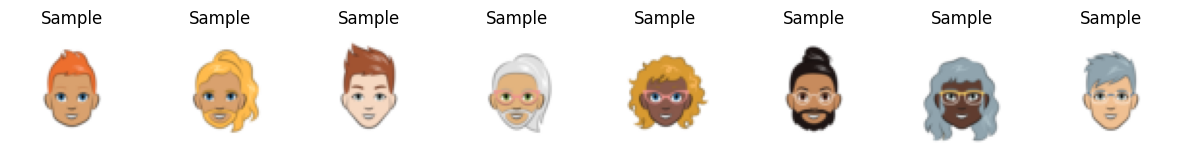

In [28]:
# Visualize a few images to ensure preprocessing didn't break them
plt.figure(figsize=(15, 4))
for i in range(8):
    plt.subplot(1, 8, i+1)
    
    # Un-normalize: [-1, 1] -> [0, 1]
    img = images[i] * 0.5 + 0.5
    
    # Convert from Tensor (C, H, W) to Numpy (H, W, C)
    img_np = img.permute(1, 2, 0).numpy()
    
    plt.imshow(img_np)
    plt.axis('off')
    plt.title("Sample")

plt.show()

In [29]:
from torch.utils.data import Subset
from models import Generator, Discriminator, weights_init
from train import train_gan
import torch

# Configuration
LATENT_DIM = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Select first 20,000 images
subset_indices = range(20000) 
official_dataset = Subset(dataset, subset_indices)

# Batch size 64 (faster/stable)
BATCH_SIZE = 64 if torch.cuda.is_available() else 32
train_loader = DataLoader(official_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Training on subset of {len(official_dataset)} images.")

# Re-initialize models
netG = Generator(latent_dim=LATENT_DIM).to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)

EPOCH = 20

G_losses, D_losses = train_gan(train_loader, netG, netD, device, epochs=EPOCH)

Training on subset of 20000 images.
Starting GAN training for 20 epochs...


Epoch 20/20: 100%|██████████| 313/313 [00:51<00:00,  6.12it/s, Loss_D=0.3778, Loss_G=4.5020, D(x)=0.82, D(Gz)=0.01]


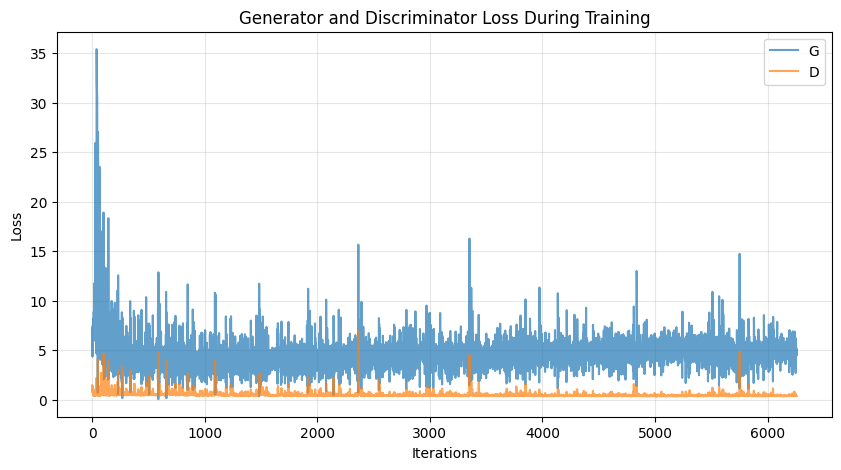

In [30]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G", alpha=0.7)
plt.plot(D_losses, label="D", alpha=0.7)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

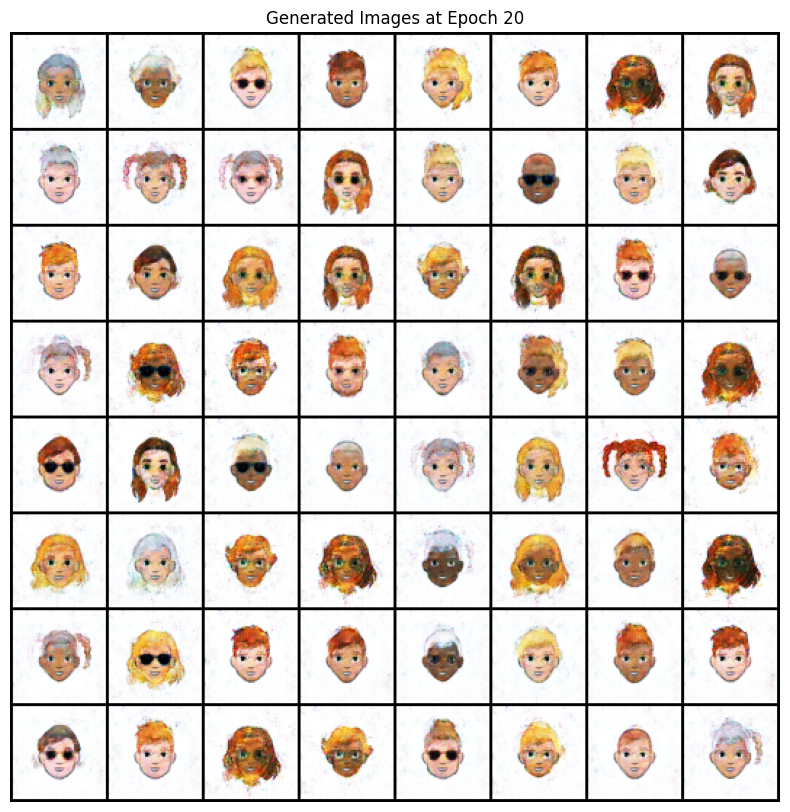

In [ ]:
import matplotlib.image as mpimg

# Load the image saved at the last epoch
last_epoch_img = f"samples/epoch_{EPOCH-1}_samples.png"

try:
    img = mpimg.imread(last_epoch_img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated Images at Epoch {EPOCH}")
    plt.show()
except FileNotFoundError:
    print("Image not found. Make sure training finished!")

In [33]:
# Save the models explicitly as "frozen" for the next phase
torch.save(netG.state_dict(), "model_artifacts/generator_frozen.pth")
torch.save(netD.state_dict(), "model_artifacts/discriminator_frozen.pth")

print("✅ Models saved as frozen. Ready for RL phase.")

✅ Models saved as frozen. Ready for RL phase.


In [ ]:
from classifier import SimpleAttributeClassifier, train_classifier

# 1. Determine Input Size
# Get one batch to check the exact metadata size
_, meta_sample = next(iter(train_loader))
META_SIZE = meta_sample.shape[1] 
print(f"Metadata Vector Size: {META_SIZE}")

# 2. Initialize Classifier
attr_classifier = SimpleAttributeClassifier(num_attributes=META_SIZE).to(device)

# 3. Train it quickly
# We use the same train_loader from before
attr_classifier = train_classifier(train_loader, attr_classifier, device, epochs=10)

# Save
torch.save(attr_classifier.state_dict(), "model_artifacts/attribute_classifier.pth")
print("✅ Classifier Trained and Saved.")

Metadata Vector Size: 217
Training Attribute Classifier for 10 epochs...
Classifier Epoch 1: Loss = 0.0692
Classifier Epoch 2: Loss = 0.0534
Classifier Epoch 3: Loss = 0.0469
Classifier Epoch 4: Loss = 0.0424
Classifier Epoch 5: Loss = 0.0389
Classifier Epoch 6: Loss = 0.0363
Classifier Epoch 7: Loss = 0.0343
Classifier Epoch 8: Loss = 0.0327
Classifier Epoch 9: Loss = 0.0313
Classifier Epoch 10: Loss = 0.0300
✅ Classifier Trained and Saved.


Training RL Agent: 100%|██████████| 10000/10000 [17:59<00:00,  9.26it/s, Avg Reward=0.52]


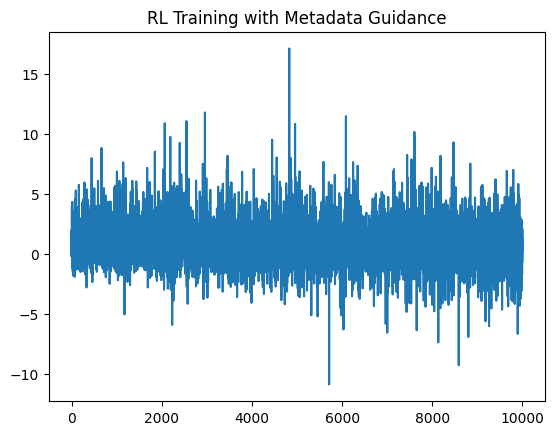

In [42]:
from train import train_rl_with_metadata

# 1. Train RL with Metadata
agent, rewards = train_rl_with_metadata(netG, netD, attr_classifier, train_loader, device, episodes=10000)

# 2. Visualize
plt.plot(rewards)
plt.title("RL Training with Metadata Guidance")
plt.show()

Visualizing 10 samples...
Scores format: [Realism (0-1) | Metadata Match (0-1)]


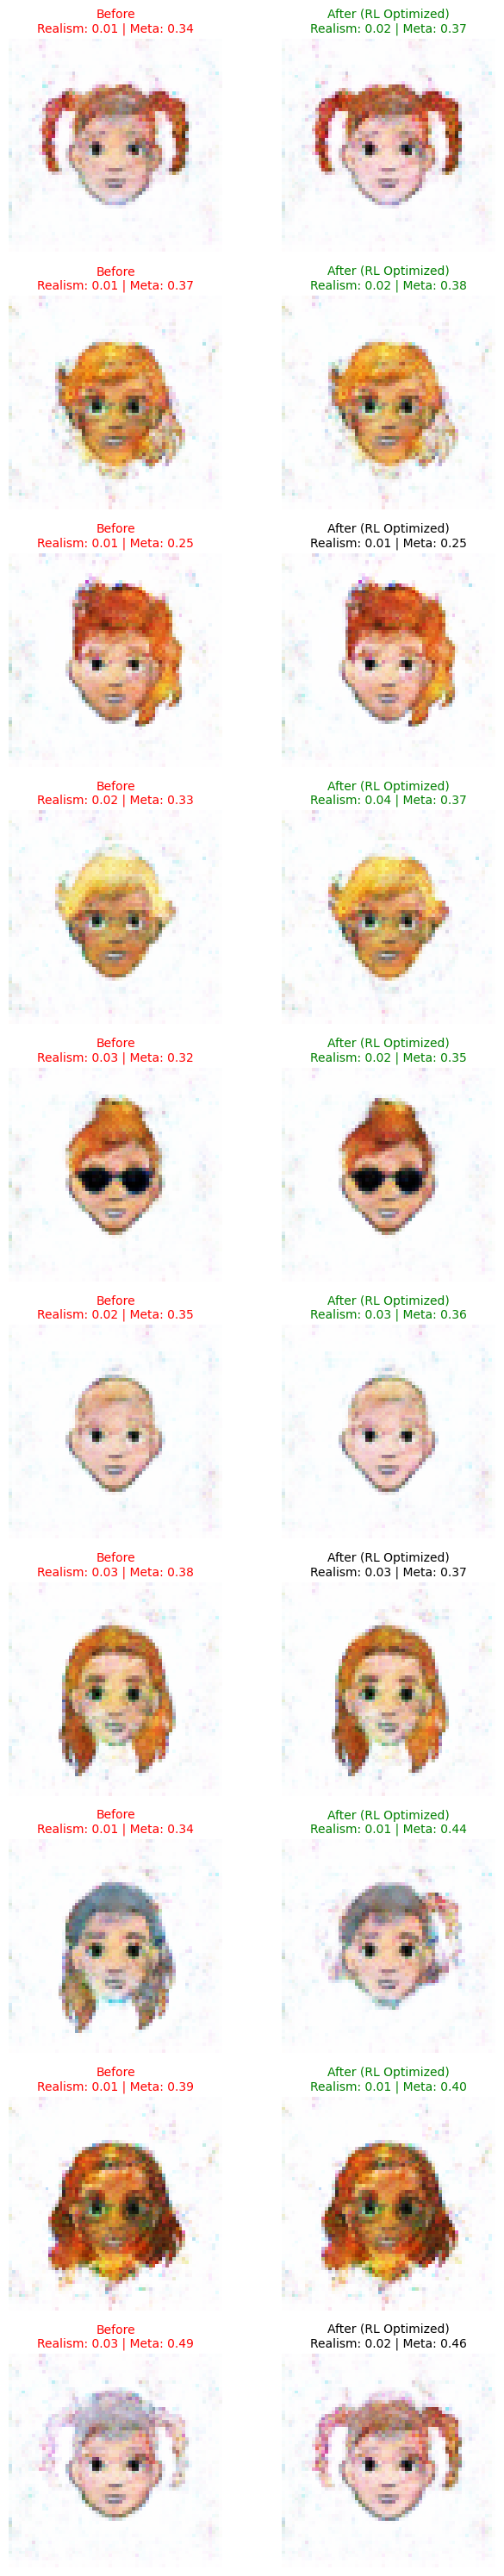

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rl_agent import GANEnvironment

def visualize_metadata_rl(agent, netG, netD, classifier, dataloader, device, num_samples=5):
    """
    Visualizes the Agent optimizing for both Realism and Metadata matching.
    """
    # 1. Get a batch of 'Real' Metadata targets from the dataset
    # We will tell the agent: "Make the generated image look like this target metadata"
    data_iter = iter(dataloader)
    _, real_metadata_batch = next(data_iter)
    real_metadata_batch = real_metadata_batch.to(device)
    
    # 2. Setup Environment
    env = GANEnvironment(netG, netD, classifier, device)
    
    plt.figure(figsize=(7, 3 * num_samples))
    
    print(f"Visualizing {num_samples} samples...")
    print("Scores format: [Realism (0-1) | Metadata Match (0-1)]")
    
    for i in range(num_samples):
        # Pick a target for this specific test
        target_meta = real_metadata_batch[i].unsqueeze(0)
        
        # --- INITIAL STATE ---
        state = env.reset(specific_target=target_meta)
        init_z = env.current_z.clone()
        
        # Calculate specific scores for display
        with torch.no_grad():
            img_init = netG(init_z)
            # Realism
            r_init = netD(img_init).item()
            # Metadata Match (Cosine Similarity)
            pred_meta_init = torch.sigmoid(classifier(img_init))
            m_init = F.cosine_similarity(pred_meta_init, target_meta).item()
            
        # --- OPTIMIZATION ---
        curr_state = state
        for _ in range(20):
            # Force Greedy = Best learned action, no randomness
            action = agent.select_action(curr_state, force_greedy=True)
            next_state, _, _, _ = env.step(action)
            curr_state = next_state
            
        # --- FINAL STATE ---
        final_z = env.current_z
        with torch.no_grad():
            img_final = netG(final_z)
            # Realism
            r_final = netD(img_final).item()
            # Metadata Match
            pred_meta_final = torch.sigmoid(classifier(img_final))
            m_final = F.cosine_similarity(pred_meta_final, target_meta).item()
            
        # --- PLOTTING ---
        # Normalize images for display
        img_init_disp = img_init[0].permute(1, 2, 0).detach().cpu().numpy() * 0.5 + 0.5
        img_final_disp = img_final[0].permute(1, 2, 0).detach().cpu().numpy() * 0.5 + 0.5
        
        # Plot Original
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img_init_disp)
        plt.axis('off')
        plt.title(f"Before\nRealism: {r_init:.2f} | Meta: {m_init:.2f}", color="red", fontsize=10)
        
        # Plot Optimized
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(img_final_disp)
        plt.axis('off')
        # If scores improved, color title green
        title_color = "green" if (r_final + m_final) > (r_init + m_init) else "black"
        plt.title(f"After (RL Optimized)\nRealism: {r_final:.2f} | Meta: {m_final:.2f}", color=title_color, fontsize=10)

    plt.tight_layout()
    plt.show()

# Run Visualization
visualize_metadata_rl(agent, netG, netD, attr_classifier, train_loader, device, num_samples=10)


STARTING FINAL EVALUATION

[1/4] Preparing Images for Evaluation...

[2/4] Calculating FID Score (Fréchet Inception Distance)...
   >> FID:  222.41197019914705

[3/4] Calculating LPIPS Score (Diversity)...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: C:\Users\User\AppData\Roaming\Python\Python310\site-packages\lpips\weights\v0.1\alex.pth
   >> Average LPIPS: 0.2115 (Higher is better, <0.05 is collapse)


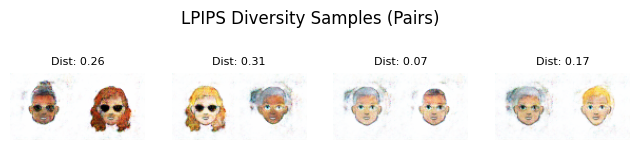


[4/4] Analyzing Discriminator Performance...
   >> Discriminator Accuracy: 61.33%


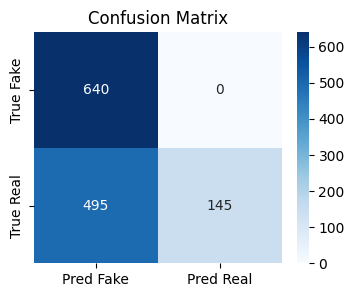

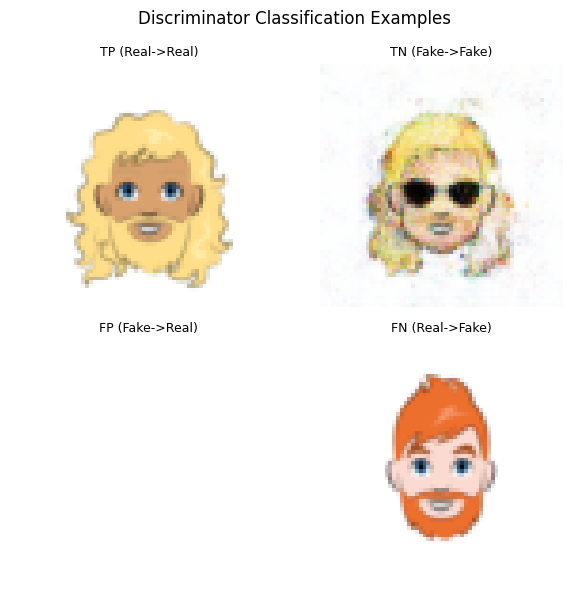

Evaluation Complete. Temporary files removed.


In [ ]:
from evaluate import evaluate

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure models are loaded
# netG.load_state_dict(torch.load("model_artifacts/generator_final.pth"))
# netD.load_state_dict(torch.load("model_artifacts/discriminator_frozen.pth"))

# Run the Full Evaluation Suite
evaluate(netG, netD, train_loader, device)

In [47]:
import os
import torch
import torchvision.utils as vutils

STUDENT_ID = "610301149"
OUTPUT_DIR = os.path.join("submission_images", STUDENT_ID)
MODEL_PATH = "model_artifacts/generator_frozen.pth"
TOTAL_IMAGES = 2000
BATCH_SIZE = 32

def generate_submission_images():
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Load the best weights
    if os.path.exists(MODEL_PATH):
        netG.load_state_dict(torch.load(MODEL_PATH))
        print(f"Loaded weights from {MODEL_PATH}")
    else:
        print("Warning: Final weights not found. Using current model state.")

    netG.eval()
    print(f"Generating {TOTAL_IMAGES} images to '{OUTPUT_DIR}'...")

    counter = 0
    device = next(netG.parameters()).device

    with torch.no_grad():
        while counter < TOTAL_IMAGES:
            # Generate a batch of latent vectors
            z = torch.randn(BATCH_SIZE, 100, 1, 1, device=device)
            fake_imgs = netG(z)

            # Save images individually to adhere to naming convention
            for i in range(fake_imgs.size(0)):
                if counter >= TOTAL_IMAGES:
                    break
                
                # Naming format: StudentID-0000.png, StudentID-0001.png, etc.
                filename = f"{STUDENT_ID}-{counter:04d}.png"
                save_path = os.path.join(OUTPUT_DIR, filename)
                
                # Normalize scales [-1, 1] to [0, 1]
                vutils.save_image(fake_imgs[i], save_path, normalize=True)
                
                counter += 1
            
            # Simple progress tracker
            if counter % 500 == 0:
                print(f"Progress: {counter}/{TOTAL_IMAGES} generated.")

    print(f"Successfully generated {counter} images.")

# Execute generation
generate_submission_images()

Loaded weights from model_artifacts/generator_frozen.pth
Generating 2000 images to 'submission_images\610301149'...
Progress: 2000/2000 generated.
Successfully generated 2000 images.


In [49]:
model = Discriminator()
model.load_state_dict(torch.load('model_artifacts/discriminator_frozen.pth'))
model.eval()

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)